In [0]:
################################################################################
# Import necessary libraries
################################################################################

from google.colab import drive
drive.mount('/content/drive/')

import os
import random
from keras import layers
from keras.backend import tf as ktf
from keras.models import load_model
import zipfile
from PIL import Image
from skimage.color import rgb2lab, lab2rgb
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
import copy

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
################################################################################
# Generator and its functions
################################################################################

# Returns numpy arrays l, a and b (w x h x 1)
def lab_img(img):
    if img.format != ("JPEG" or "JPG"):
        img = img.convert("RGB")
    img = rgb2lab(img)

    l = img[:, :, 0]

    l = (np.array(l) / 100) * 2 - 1

    l = np.expand_dims(l, axis=2)

    return l


# Returns batch of x and y values packed together
def batch_images(image_path, imgs, trained_model):
    with imgs.open(image_path) as img:
        img = Image.open(img)
        w, h = img.size
        
        while w % 16 != 0:
            w += 1
        
        while h % 16 != 0:
            h += 1
        
        img = img.resize((w, h))
        
        s = predict_segmentation(img.convert("L").convert("RGB"), trained_model)
        l = lab_img(img)

        return np.expand_dims(l, axis=0), np.expand_dims(s, axis=0)


# Returns one-hot encoded segmentation object (w x h x 150)
def predict_segmentation(img, trained_model):
    # TODO: do this in my model
    data_mean = np.array([[[123.68, 116.779, 103.939]]])
    input_size = (473, 473)
    output_size = (img.size[0] / 16, img.size[1] / 16)

    if img.size != input_size:
        img = img.resize(input_size)

    pixel_img = np.array(img)
    pixel_img = pixel_img - data_mean
    bgr_img = pixel_img[:, :, ::-1]
    segmented_img = trained_model.predict(np.expand_dims(bgr_img, 0))[0]
    if output_size != input_size:
          segmented_img = resize(segmented_img,
                                 (output_size[1], output_size[0], 150),
                                  mode="constant",
                                  preserve_range=True)
    return segmented_img


# Yields batches of x and y values
def generator_fn(n_images, images_path, trained_model):
    with zipfile.ZipFile(images_path) as imgs:
        image_paths = imgs.infolist()
        random.shuffle(image_paths)
        i = 0
        while True:
            if i == n_images:
                i = 0
            x, s = batch_images(image_paths[i], imgs, trained_model)
            i += 1
            yield x, s


In [0]:
################################################################################
# Loading, training and saving model
################################################################################

class Interp(layers.Layer):

    def __init__(self, new_size, **kwargs):
        self.new_size = new_size
        super(Interp, self).__init__(**kwargs)

    def build(self, input_shape):
        super(Interp, self).build(input_shape)

    def call(self, inputs, **kwargs):
        new_height, new_width = self.new_size
        resized = ktf.image.resize_images(inputs, [new_height, new_width],
                                          align_corners=True)
        return resized

    def compute_output_shape(self, input_shape):
        return tuple([None, self.new_size[0], self.new_size[1], input_shape[3]])

    def get_config(self):
        config = super(Interp, self).get_config()
        config['new_size'] = self.new_size
        return config


# Returns trained model instance
def load_trained_model(path):
    trained_model = load_model(path, custom_objects={'Interp': Interp})
    trained_model._make_predict_function()
    return trained_model
  

In [0]:
Label = namedtuple('Label', [
    'name',
    'id',
    'color',
    'count'
])
labels = [Label('wall', 0, (120, 120, 120), 0),
        Label('building', 1, (180, 120, 120), 0),
        Label('sky', 2, (6, 230, 230), 0),
        Label('floor', 3, (80, 50, 50), 0),
        Label('tree', 4, (4, 200, 3), 0),
        Label('ceiling', 5, (120, 120, 80), 0),
        Label('road', 6, (140, 140, 140), 0),
        Label('bed', 7, (204, 5, 255), 0),
        Label('windowpane', 8, (230, 230, 230), 0),
        Label('grass', 9, (4, 250, 7), 0),
        Label('cabinet', 10, (224, 5, 255), 0),
        Label('sidewalk', 11, (235, 255, 7), 0),
        Label('person', 12, (150, 5, 61), 0),
        Label('earth', 13, (120, 120, 70), 0),
        Label('door', 14, (8, 255, 51), 0),
        Label('table', 15, (255, 6, 82), 0),
        Label('mountain', 16, (143, 255, 140), 0),
        Label('plant', 17, (204, 255, 4), 0),
        Label('curtain', 18, (255, 51, 7), 0),
        Label('chair', 19, (204, 70, 3), 0),
        Label('car', 20, (0, 102, 200), 0),
        Label('water', 21, (61, 230, 250), 0),
        Label('painting', 22, (255, 6, 51), 0),
        Label('sofa', 23, (11, 102, 255), 0),
        Label('shelf', 24, (255, 7, 71), 0),
        Label('house', 25, (255, 9, 224), 0),
        Label('sea', 26, (9, 7, 230), 0),
        Label('mirror', 27, (220, 220, 220), 0),
        Label('rug', 28, (255, 9, 92), 0),
        Label('field', 29, (112, 9, 255), 0),
        Label('armchair', 30, (8, 255, 214), 0),
        Label('seat', 31, (7, 255, 224), 0),
        Label('fence', 32, (255, 184, 6), 0),
        Label('desk', 33, (10, 255, 71), 0),
        Label('rock', 34, (255, 41, 10), 0),
        Label('wardrobe', 35, (7, 255, 255), 0),
        Label('lamp', 36, (224, 255, 8), 0),
        Label('bathtub', 37, (102, 8, 255), 0),
        Label('railing', 38, (255, 61, 6), 0),
        Label('cushion', 39, (255, 194, 7), 0),
        Label('base', 40, (255, 122, 8), 0),
        Label('box', 41, (0, 255, 20), 0),
        Label('column', 42, (255, 8, 41), 0),
        Label('signboard', 43, (255, 5, 153), 0),
        Label('chest of drawers', 44, (6, 51, 255), 0),
        Label('counter', 45, (235, 12, 255), 0),
        Label('sand', 46, (160, 150, 20), 0),
        Label('sink', 47, (0, 163, 255), 0),
        Label('skyscraper', 48, (140, 140, 140), 0),
        Label('fireplace', 49, (250, 10, 15), 0),
        Label('refrigerator', 50, (20, 255, 0), 0),
        Label('grandstand', 51, (31, 255, 0), 0),
        Label('path', 52, (255, 31, 0), 0),
        Label('stairs', 53, (255, 224, 0), 0),
        Label('runway', 54, (153, 255, 0), 0),
        Label('case', 55, (0, 0, 255), 0),
        Label('pool table', 56, (255, 71, 0), 0),
        Label('pillow', 57, (0, 235, 255), 0),
        Label('screen door', 58, (0, 173, 255), 0),
        Label('stairway', 59, (31, 0, 255), 0),
        Label('river', 60, (11, 200, 200), 0),
        Label('bridge', 61, (255, 82, 0), 0),
        Label('bookcase', 62, (0, 255, 245), 0),
        Label('blind', 63, (0, 61, 255), 0),
        Label('coffee table', 64, (0, 255, 112), 0),
        Label('toilet', 65, (0, 255, 133), 0),
        Label('flower', 66, (255, 0, 0), 0),
        Label('book', 67, (255, 163, 0), 0),
        Label('hill', 68, (255, 102, 0), 0),
        Label('bench', 69, (194, 255, 0), 0),
        Label('countertop', 70, (0, 143, 255), 0),
        Label('stove', 71, (51, 255, 0), 0),
        Label('palm', 72, (0, 82, 255), 0),
        Label('kitchen island', 73, (0, 255, 41), 0),
        Label('computer', 74, (0, 255, 173), 0),
        Label('swivel chair', 75, (10, 0, 255), 0),
        Label('boat', 76, (173, 255, 0), 0),
        Label('bar', 77, (0, 255, 153), 0),
        Label('arcade machine', 78, (255, 92, 0), 0),
        Label('hovel', 79, (255, 0, 255), 0),
        Label('bus', 80, (255, 0, 245), 0),
        Label('towel', 81, (255, 0, 102), 0),
        Label('light', 82, (255, 173, 0), 0),
        Label('truck', 83, (255, 0, 20), 0),
        Label('tower', 84, (255, 184, 184), 0),
        Label('chandelier', 85, (0, 31, 255), 0),
        Label('awning', 86, (0, 255, 61), 0),
        Label('streetlight', 87, (0, 71, 255), 0),
        Label('booth', 88, (255, 0, 204), 0),
        Label('television receiver', 89, (0, 255, 194), 0),
        Label('airplane', 90, (0, 255, 82), 0),
        Label('dirt track', 91, (0, 10, 255), 0),
        Label('apparel', 92, (0, 112, 255), 0),
        Label('pole', 93, (51, 0, 255), 0),
        Label('land', 94, (0, 194, 255), 0),
        Label('bannister', 95, (0, 122, 255), 0),
        Label('escalator', 96, (0, 255, 163), 0),
        Label('ottoman', 97, (255, 153, 0), 0),
        Label('bottle', 98, (0, 255, 10), 0),
        Label('buffet', 99, (255, 112, 0), 0),
        Label('poster', 100, (143, 255, 0), 0),
        Label('stage', 101, (82, 0, 255), 0),
        Label('van', 102, (163, 255, 0), 0),
        Label('ship', 103, (255, 235, 0), 0),
        Label('fountain', 104, (8, 184, 170), 0),
        Label('conveyer belt', 105, (133, 0, 255), 0),
        Label('canopy', 106, (0, 255, 92), 0),
        Label('washer', 107, (184, 0, 255), 0),
        Label('plaything', 108, (255, 0, 31), 0),
        Label('swimming pool', 109, (0, 184, 255), 0),
        Label('stool', 110, (0, 214, 255), 0),
        Label('barrel', 111, (255, 0, 112), 0),
        Label('basket', 112, (92, 255, 0), 0),
        Label('waterfall', 113, (0, 224, 255), 0),
        Label('tent', 114, (112, 224, 255), 0),
        Label('bag', 115, (70, 184, 160), 0),
        Label('minibike', 116, (163, 0, 255), 0),
        Label('cradle', 117, (153, 0, 255), 0),
        Label('oven', 118, (71, 255, 0), 0),
        Label('ball', 119, (255, 0, 163), 0),
        Label('food', 120, (255, 204, 0), 0),
        Label('step', 121, (255, 0, 143), 0),
        Label('tank', 122, (0, 255, 235), 0),
        Label('trade name', 123, (133, 255, 0), 0),
        Label('microwave', 124, (255, 0, 235), 0),
        Label('pot', 125, (245, 0, 255), 0),
        Label('animal', 126, (255, 0, 122), 0),
        Label('bicycle', 127, (255, 245, 0), 0),
        Label('lake', 128, (10, 190, 212), 0),
        Label('dishwasher', 129, (214, 255, 0), 0),
        Label('screen', 130, (0, 204, 255), 0),
        Label('blanket', 131, (20, 0, 255), 0),
        Label('sculpture', 132, (255, 255, 0), 0),
        Label('hood', 133, (0, 153, 255), 0),
        Label('sconce', 134, (0, 41, 255), 0),
        Label('vase', 135, (0, 255, 204), 0),
        Label('traffic light', 136, (41, 0, 255), 0),
        Label('tray', 137, (41, 255, 0), 0),
        Label('ashcan', 138, (173, 0, 255), 0),
        Label('fan', 139, (0, 245, 255), 0),
        Label('pier', 140, (71, 0, 255), 0),
        Label('crt screen', 141, (122, 0, 255), 0),
        Label('plate', 142, (0, 255, 184), 0),
        Label('monitor', 143, (0, 92, 255), 0),
        Label('bulletin board', 144, (184, 255, 0), 0),
        Label('shower', 145, (0, 133, 255), 0),
        Label('radiator', 146, (255, 214, 0), 0),
        Label('glass', 147, (25, 194, 194), 0),
        Label('clock', 148, (102, 255, 0), 0),
        Label('flag', 149, (92, 0, 255), 0)]


def class_to_color(n):
    global n_labels
    n_labels[int(n)] = n_labels[int(n)]._replace(count=n_labels[int(n)].count + 1)
    return n_labels[int(n)].color


# Takes one instance of input and output (no batches)
def decode_images(l, s, y, save_path):
    global n_labels
    h, w, d = l.shape
    a, b = np.split(y[0], [1], 2)
    l = (l[:, :, 0] + 1) * 100 / 2
    a = (a[:, :, 0] + 1) * 255 / 2 - 127
    b = (b[:, :, 0] + 1) * 255 / 2 - 128

    # if there is some upsampling and downsampling going on in the model
    if l.shape != s.shape:
        s = resize(s, (h, w, 150), mode="constant", preserve_range=True)

    # index to save the images under
    i = 0
    while os.path.isfile(os.path.join(save_path, str(i) + "_segmentation.jpg")):
        i += 1

    n_labels = copy.deepcopy(labels)
    colored_segmentation = np.zeros((h, w, 3))
    semantic_segmentation_2d = np.argmax(s, axis=2)
    for x in range(h):
        for y in range(w):
            colored_segmentation[x, y] = class_to_color(semantic_segmentation_2d[x, y])
    Image.fromarray(colored_segmentation.astype('uint8')).save(os.path.join(save_path, str(i) + "_segmentation.jpg"))

    n_labels_sorted = sorted(n_labels, key=lambda a: a.count, reverse=True)
    x_axis = [x.name for x in n_labels_sorted[0:7]]
    y_axis = [x.count for x in n_labels_sorted[0:7]]
    colors = ["#%02x%02x%02x" % x.color for x in n_labels_sorted[0:7]]
    pos = np.arange(len(x_axis))
    plt.bar(pos, y_axis, color=colors)
    plt.xticks(pos, x_axis)
    plt.savefig(os.path.join(save_path, str(i) + "_segmentation_labels.png"))
    # needed to delete current plot
    plt.show()

    bnw_input = np.zeros((h, w, 3))
    bnw_input[:, :, 0] = l
    Image.fromarray((lab2rgb(bnw_input)*255).astype('uint8')).save(os.path.join(save_path, str(i) + "_input.jpg"))

    color_output = np.zeros((h, w, 3))
    color_output[:, :, 0] = l
    color_output[:, :, 1] = a
    color_output[:, :, 2] = b
    Image.fromarray((lab2rgb(color_output)*255).astype('uint8')).save(os.path.join(save_path, str(i) + "_output.jpg"))

    color_output = np.zeros((h, w, 3))
    color_output[:, :, 0] = np.full((h, w), 70)
    color_output[:, :, 1] = a
    color_output[:, :, 2] = b
    Image.fromarray((lab2rgb(color_output)*255).astype('uint8')).save(os.path.join(save_path, str(i) + "_output_labels.jpg"))


# visualizes images of first batch generated by generator_fn
def validate_images(n_images, model, generator_fn, save_path):
    for i in range(n_images):
        x, s = next(generator_fn)
        y = model.predict([x, s])
        decode_images(x[0], s[0], y, save_path)

mkdir: cannot create directory ‘drive/My Drive/Validation/9th_gen’: File exists


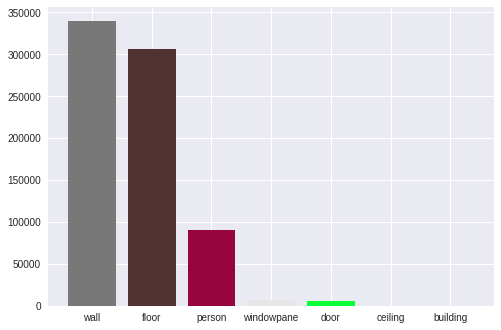

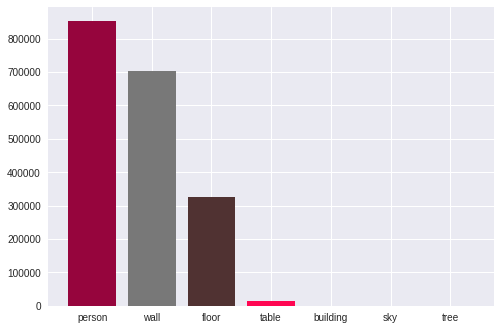

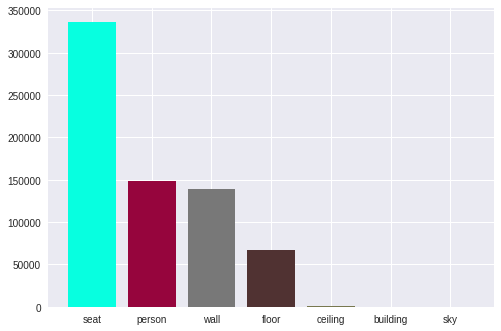

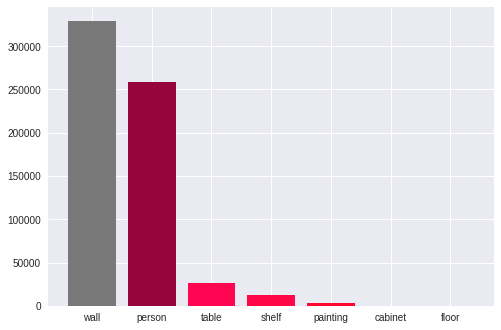

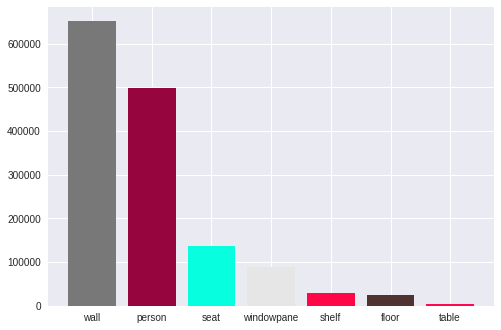

In [0]:
################################################################################
# Control panel
################################################################################

n_images = 5
!mkdir drive/My\ Drive/Validation/9th_gen

images_path = "drive/My Drive/Datasets/bw_test_dataset.zip"
images_destination = "drive/My Drive/Validation/9th_gen"
trained_model = load_trained_model("drive/My Drive/Models/pspnet.h5")
colorization_model = load_model("drive/My Drive/Models/Checkpoints/9th_gen.hdf5")
validation_data_fn = generator_fn(n_images, images_path, trained_model)

validate_images(n_images, colorization_model, validation_data_fn, images_destination)
